In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import joblib
from datetime import datetime

Load and clean tennis data

In [2]:
def load_and_clean_data():
    
    # Load data
    df = pd.read_csv('atp_tennis.csv')
    print(f"Original dataset: {len(df):,} matches")
    
    # Convert date and filter to 2022-2024
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df = df[df['Year'].isin([2022, 2023, 2024])]
    
    # Remove missing rankings and filter top 300
    df = df[(df['Rank_1'] != -1) & (df['Rank_2'] != -1)]
    df = df[(df['Rank_1'] <= 300) & (df['Rank_2'] <= 300)]
    
    # Clean surfaces and create target
    df['Surface'] = df['Surface'].replace({'Carpet': 'Hard'})
    df['Player_1_wins'] = (df['Winner'] == df['Player_1']).astype(int)
    
    print(f"Cleaned dataset: {len(df):,} matches")
    return df


Create features for modeling

In [3]:
def create_features(df):
   
    # Ranking features
    df['rank_diff_abs'] = abs(df['Rank_1'] - df['Rank_2'])
    df['higher_ranked_player1'] = (df['Rank_1'] < df['Rank_2']).astype(int)
    df['rank_advantage'] = np.log(df['Rank_2'] / df['Rank_1'])
    
    # Additional features
    df['both_top50'] = ((df['Rank_1'] <= 50) & (df['Rank_2'] <= 50)).astype(int)
    df['rank_gap_large'] = (df['rank_diff_abs'] > 50).astype(int)
    
    # Surface dummies
    surface_dummies = pd.get_dummies(df['Surface'], prefix='surface')
    df = pd.concat([df, surface_dummies], axis=1)
    
    return df


Create exploratory data analysis plots

In [5]:
def create_visualizations(df):
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Tennis Match Analysis (2022-2024)', fontsize=14)
    
    # 1. Win rate by ranking difference
    rank_bins = range(-150, 151, 25)
    win_rates, bin_centers = [], []
    
    for i in range(len(rank_bins)-1):
        mask = (df['Rank_1'] - df['Rank_2'] >= rank_bins[i]) & (df['Rank_1'] - df['Rank_2'] < rank_bins[i+1])
        if mask.sum() > 20:
            win_rates.append(df[mask]['Player_1_wins'].mean())
            bin_centers.append((rank_bins[i] + rank_bins[i+1]) / 2)
    
    axes[0,0].plot(bin_centers, win_rates, 'b-o')
    axes[0,0].set_xlabel('Ranking Difference')
    axes[0,0].set_ylabel('Player 1 Win Rate')
    axes[0,0].set_title('Win Rate vs Ranking Difference')
    axes[0,0].axhline(y=0.5, color='r', linestyle='--', alpha=0.7)
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Win rate by surface
    surface_stats = []
    for surface in ['Clay', 'Grass', 'Hard']:
        col = f'surface_{surface}'
        if col in df.columns:
            mask = df[col] == 1
            surface_stats.append({
                'Surface': surface, 
                'Win_Rate': df[mask]['Player_1_wins'].mean(),
                'Count': mask.sum()
            })
    
    surface_df = pd.DataFrame(surface_stats)
    bars = axes[0,1].bar(surface_df['Surface'], surface_df['Win_Rate'])
    axes[0,1].set_ylabel('Player 1 Win Rate')
    axes[0,1].set_title('Win Rate by Surface')
    axes[0,1].set_ylim(0.4, 0.6)
    
    # 3. Ranking distribution
    axes[1,0].hist(df['Rank_1'], bins=20, alpha=0.7, label='Player 1')
    axes[1,0].hist(df['Rank_2'], bins=20, alpha=0.7, label='Player 2')
    axes[1,0].set_xlabel('Ranking')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Ranking Distribution')
    axes[1,0].legend()
    
    # 4. Yearly distribution
    yearly = df['Year'].value_counts().sort_index()
    axes[1,1].bar(yearly.index, yearly.values)
    axes[1,1].set_xlabel('Year')
    axes[1,1].set_ylabel('Matches')
    axes[1,1].set_title('Matches by Year')
    
    plt.tight_layout()
    plt.savefig('tennis_analysis.png', dpi=300, bbox_inches='tight')
    print("Visualizations saved to tennis_analysis.png")


In [ ]:
Train the model

In [6]:
def train_model(df):
    
    # Define features
    feature_cols = [
        'rank_diff_abs', 'higher_ranked_player1', 'rank_advantage',
        'surface_Clay', 'surface_Grass', 'surface_Hard',
        'both_top50', 'rank_gap_large'
    ]
    
    X = df[feature_cols]
    y = df['Player_1_wins']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Train logistic regression
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Evaluate
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    
    print(f"Training Accuracy: {train_acc:.3f}")
    print(f"Test Accuracy: {test_acc:.3f}")
    
    # Feature importance
    importance = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': model.coef_[0]
    }).sort_values('Coefficient', key=abs, ascending=False)
    
    print("\nFeature Importance:")
    for _, row in importance.head(5).iterrows():
        print(f"  {row['Feature']}: {row['Coefficient']:.3f}")
    
    return model, feature_cols, train_acc, test_acc

Save the model

In [7]:
def save_model(model, feature_cols, train_acc, test_acc):
    
    model_data = {
        'model': model,
        'feature_columns': feature_cols,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'created_date': datetime.now().isoformat()
    }
    
    # Save model
    with open('tennis_model.pkl', 'wb') as f:
        pickle.dump(model_data, f)
    
    joblib.dump(model, 'tennis_model.joblib')
    print("Model saved to tennis_model.pkl and tennis_model.joblib")


Predicting

In [8]:
def predict_match(model, feature_cols, rank1, rank2, surface='Hard'):
    features = {
        'rank_diff_abs': abs(rank1 - rank2),
        'higher_ranked_player1': 1 if rank1 < rank2 else 0,
        'rank_advantage': np.log(rank2 / rank1) if rank1 > 0 and rank2 > 0 else 0,
        'surface_Clay': 1 if surface == 'Clay' else 0,
        'surface_Grass': 1 if surface == 'Grass' else 0,
        'surface_Hard': 1 if surface == 'Hard' else 0,
        'both_top50': 1 if (rank1 <= 50 and rank2 <= 50) else 0,
        'rank_gap_large': 1 if abs(rank1 - rank2) > 50 else 0
    }
    
    X_pred = np.array([list(features.values())])
    prob = model.predict_proba(X_pred)[0][1]
    
    return {
        'player1_win_prob': prob,
        'player2_win_prob': 1 - prob,
        'favorite': 'Player 1' if prob > 0.5 else 'Player 2'
    }

Tennis Match Prediction Analysis
Original dataset: 65,974 matches
Cleaned dataset: 7,381 matches
Visualizations saved to tennis_analysis.png
Training Accuracy: 0.631
Test Accuracy: 0.627

Feature Importance:
  rank_advantage: 0.545
  rank_gap_large: 0.221
  surface_Clay: 0.051
  surface_Grass: -0.043
  higher_ranked_player1: -0.027
Model saved to tennis_model.pkl and tennis_model.joblib

Example Predictions:
Rank 5 vs 25 on Hard: 69.5% - 30.5%
Rank 10 vs 50 on Clay: 69.7% - 30.3%
Rank 1 vs 100 on Grass: 92.3% - 7.7%

Analysis complete. Files saved:
- tennis_model.pkl (trained model)
- tennis_cleaned.csv (clean data)
- tennis_analysis.png (visualizations)


/Users/cz/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/cz/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/cz/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


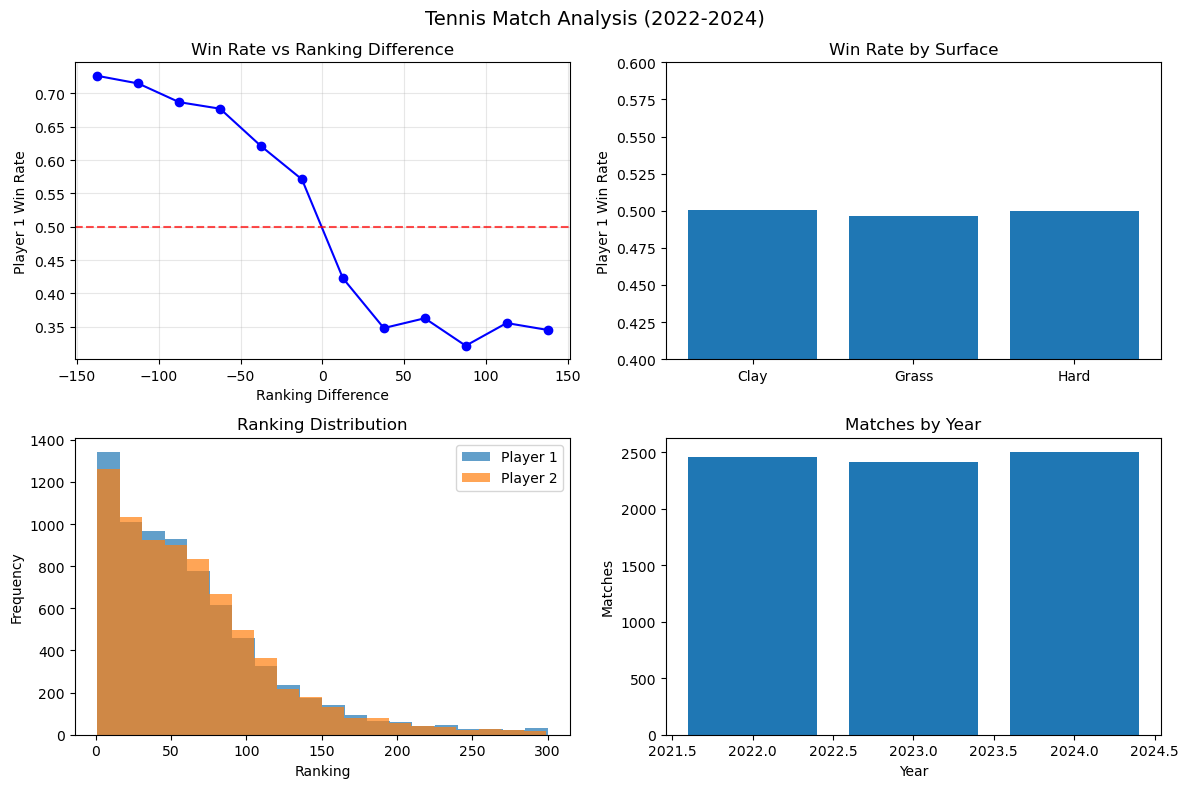

In [9]:
def main():
    """Main analysis pipeline"""
    print("Tennis Match Prediction Analysis")
    print("=" * 40)
    
    # Load and clean data
    df = load_and_clean_data()
    
    # Create features
    df = create_features(df)
    
    # Create visualizations
    create_visualizations(df)
    
    # Train model
    model, feature_cols, train_acc, test_acc = train_model(df)
    
    # Save everything
    save_model(model, feature_cols, train_acc, test_acc)
    df.to_csv('tennis_cleaned.csv', index=False)
    
    # Test predictions
    print("\nExample Predictions:")
    examples = [(5, 25, 'Hard'), (10, 50, 'Clay'), (1, 100, 'Grass')]
    
    for rank1, rank2, surface in examples:
        pred = predict_match(model, feature_cols, rank1, rank2, surface)
        print(f"Rank {rank1} vs {rank2} on {surface}: {pred['player1_win_prob']:.1%} - {pred['player2_win_prob']:.1%}")
    
    print("\nAnalysis complete. Files saved:")
    print("- tennis_model.pkl (trained model)")
    print("- tennis_cleaned.csv (clean data)")
    print("- tennis_analysis.png (visualizations)")

if __name__ == "__main__":
    main()